<a href="https://colab.research.google.com/github/SonaMaharjan/Emotion-Detector/blob/master/EmotionDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python

In [0]:
!pip install git+git://github.com/PnS2019/pnslib.git

In [0]:
!wget https://pns2019.github.io/images/Lenna.png

In [0]:

!pip install tensorflow==2.0.0-beta1

  Using cached https://files.pythonhosted.org/packages/29/6c/2c9a5c4d095c63c2fb37d20def0e4f92685f7aee9243d6aae25862694fd1/tensorflow-2.0.0b1-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: tensorflow 2.0.0
    Uninstalling tensorflow-2.0.0:
      Successfully uninstalled tensorflow-2.0.0


In [0]:
!pip install tensorflow==2.0.0

  Using cached https://files.pythonhosted.org/packages/46/0f/7bd55361168bb32796b360ad15a25de6966c9c1beb58a8e30c01c8279862/tensorflow-2.0.0-cp36-cp36m-manylinux2010_x86_64.whl
  Found existing installation: tensorflow 2.0.0b1
    Uninstalling tensorflow-2.0.0b1:
      Successfully uninstalled tensorflow-2.0.0b1


In [0]:
from google.colab import files
file = files.upload()

In [0]:
from __future__ import print_function
import numpy as np

# get the data
filename = 'fer2013.csv'
label = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [0]:
def data(filename):
    X=[]
    Y=[]
    lines = open(filename)
    skip = True #this is to skip the first line (title) of the dataset 
    for l in lines:
      if skip:
        skip = False
      else:
        row = l.split(',')
        
        p =[]
        for i in row[1].split():
            p.append(int(i))
        X.append(p)
        Y.append(int(row[0]))
        # X.append([int(p) for p in row[1].split()])
    X, Y = np.array(X)/255.0, np.array(Y)
    return X, Y

In [0]:
X, Y = data(filename)
print (X, Y)

In [0]:
#This is not needed 

num_class = len(set(Y))

# To see number of training data point available for each label
def balance_class(Y):
    num_class = set(Y)
    count_class = {}
    for i in range(len(num_class)):
        count_class[i] = sum([1 for y in Y if y == i])
    return count_class

balance = balance_class(Y)
print (balance)

In [0]:
N, D = X.shape
print (N, D)


35887 2304


In [0]:
X = X.reshape(N, 48, 48, 1)
print (X)

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)

In [0]:
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.metrics import categorical_accuracy
from keras.models import model_from_json

from keras.optimizers import *
from keras.layers.normalization import BatchNormalization

batch_size = 128
epochs = 124 

#Main CNN model with four Convolution layer & two fully connected layer
def baseline_model():
    # Initialising the CNN
    model = Sequential()

    # 1 - Convolution
    model.add(Conv2D(64,(3,3), border_mode='same', input_shape=(48, 48,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # 2nd Convolution layer
    model.add(Conv2D(128,(5,5), border_mode='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # 3rd Convolution layer
    model.add(Conv2D(512,(3,3), border_mode='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # 4th Convolution layer
    model.add(Conv2D(512,(3,3), border_mode='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Flattening
    model.add(Flatten())

    # Fully connected layer 1st layer
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))


    # Fully connected layer 2nd layer
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(num_class, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[categorical_accuracy])
    return model


In [0]:
def baseline_model_saved():
    #load json and create model
    json_file = open('model', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    #load weights from h5 file
    model.load_weights("model.h5")
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[categorical_accuracy])
    return model

In [0]:
#### DO NOT RUN THIS PLEASE #####
is_model_saved = False

# If model is not saved train the CNN model otherwise just load the weights
if(is_model_saved==False ):
    # Train model
    model = baseline_model()
    # Note : 3259 samples is used as validation data &   28,709  as training samples

    model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=2,
              validation_split=0.1111)
    model_json = model.to_json()
    with open("model-eg.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save("model-eg.h5")
    print("Saved model to disk")
else:
    # Load the trained model
    print("Load model from disk")
    model = baseline_model_saved()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(48, 48, 1..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (5, 5), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), padding="same")`


Train on 28709 samples, validate on 3589 samples
Epoch 1/124
 - 28s - loss: 0.3882 - categorical_accuracy: 0.3177 - val_loss: 0.3605 - val_categorical_accuracy: 0.3717
Epoch 2/124
 - 25s - loss: 0.3163 - categorical_accuracy: 0.4587 - val_loss: 0.3135 - val_categorical_accuracy: 0.4617
Epoch 3/124
 - 25s - loss: 0.2856 - categorical_accuracy: 0.5239 - val_loss: 0.2769 - val_categorical_accuracy: 0.5263
Epoch 4/124
 - 25s - loss: 0.2688 - categorical_accuracy: 0.5552 - val_loss: 0.2954 - val_categorical_accuracy: 0.4946
Epoch 5/124
 - 25s - loss: 0.2562 - categorical_accuracy: 0.5795 - val_loss: 0.2826 - val_categorical_accuracy: 0.5274
Epoch 6/124
 - 25s - loss: 0.2468 - categorical_accuracy: 0.6002 - val_loss: 0.3175 - val_categorical_accuracy: 0.4664
Epoch 7/124
 - 25s - loss: 0.2377 - categorical_accuracy: 0.6163 - val_loss: 0.2748 - val_categorical_accuracy: 0.5288
Epoch 8/124
 - 25s - loss: 0.2266 - categorical_accuracy: 0.6369 - val_loss: 0.2606 - val_categorical_accuracy: 0.5687

In [259]:
# Model will predict the probability values for 7 labels for a test image
score = model.predict(X_test)
print (model.summary())

new_X = [ np.argmax(item) for item in score ]
y_test2 = [ np.argmax(item) for item in y_test]

# Calculating categorical accuracy taking label having highest probability
accuracy = [ (x==y) for x,y in zip(new_X,y_test2) ]
print(" Accuracy on Test set : " , np.mean(accuracy))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_7 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
activation_7 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_8 (Batch (None, 24, 24, 128)      

In [0]:
!pip install git+git://github.com/PnS2019/pnslib.git

In [0]:
!wget https://pns2019.github.io/images/Lenna.png

--2019-11-25 11:39:24--  https://pns2019.github.io/images/Lenna.png
Resolving pns2019.github.io (pns2019.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to pns2019.github.io (pns2019.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473831 (463K) [image/png]
Saving to: ‘Lenna.png’

Lenna.png           100%[===================>] 462.73K  --.-KB/s    in 0.05s   

2019-11-25 11:39:25 (9.07 MB/s) - ‘Lenna.png’ saved [473831/473831]



In [0]:
import numpy as np
import cv2
from pnslib import utils
import matplotlib.pyplot as plt
import sys
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

In [0]:
facedict = {}

In [0]:
def take_photo(filename='photo.jpg', quality=0.8, width = 2304, height = 2304):
  # Image("bp.png", width=100, height=100)
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [0]:
# face_cascade = cv2.CascadeClassifier('/content/sample_data/haarcascade_frontalface_default.xml.html')
# eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml') 
face_cascade = cv2.CascadeClassifier(
    utils.get_haarcascade_path('haarcascade_frontalface_default.xml'))
eye_cascade = cv2.CascadeClassifier(
    utils.get_haarcascade_path('haarcascade_eye.xml'))

<IPython.core.display.Javascript object>

Saved to photo.jpg


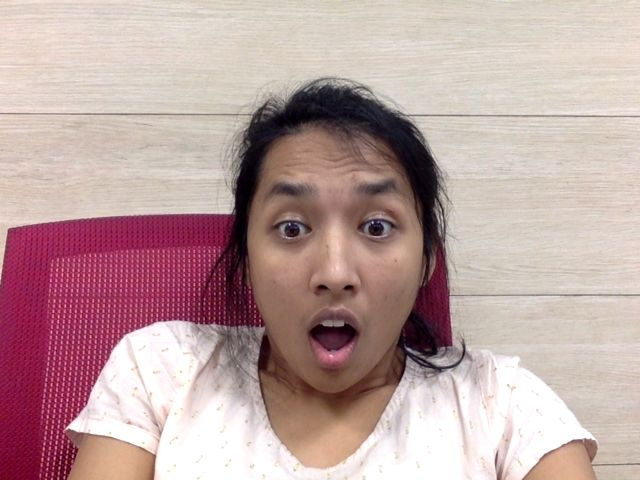

In [314]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [0]:
from keras.models import load_model
from keras.preprocessing import image
import os
# import cv2
# import numpy as np
from os import listdir
from os.path import isfile, join
from keras.preprocessing.image import img_to_array

In [0]:
emotion_classifier = load_model('model-eg.h5')

In [0]:
def face_detector(img):
    # Convert image to grayscale
    gray = cv2.cvtColor(img.copy(),cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    if faces is ():
        return (0,0,0,0), np.zeros((48,48), np.uint8), img
    
    allfaces = []   
    rects = []
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_gray = cv2.resize(roi_gray, (48, 48), interpolation = cv2.INTER_AREA)
        allfaces.append(roi_gray)
        rects.append((x,w,y,h))
    return rects, allfaces, img

In [0]:
image = cv2.imread("photo.jpg")
rects, faces, image = face_detector(image)
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# plt.imshow(image)

In [0]:
i = 0
for face in faces:
    roi = face.astype("float") / 255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)

    # make a prediction on the ROI, then lookup the class
    pred = emotion_classifier.predict(roi)[0]
    name = label[pred.argmax()]   

    #Overlay our detected emotion on our pic
    label_position = (rects[i][0] + int((rects[i][1]/2)), abs(rects[i][2] - 10))
    i =+ 1
    cv2.putText(img, name, label_position , cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 2)
    


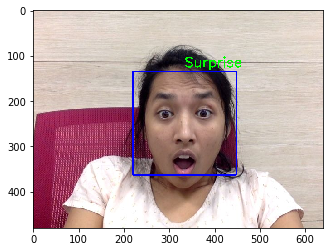

In [320]:
plt.figure()
plt.imshow(img)
plt.show()
# cv2.waitKey(0)

# cv2.destroyAllWindows()